# Ritwika Mukhopadhyay: Comparative Analysis of the prediction of AGB using Random Forest Regression, Support Vector Machine for Regression & FeedForward Neural Network

[Presentation](http://spatial-ecology.net/docs/source/STUDENTSPROJECTS/Proj_2022_Matera/Prediction_of_AGB_using_RFR_SVR_FFNN_Ritwika_Mukhopadhyay.pdf)  
[Video recording](https://youtu.be/5KthbToljUc)

# Project Description
The main objective was to predict forest aboveground biomass (AGB) with the metrics derived from airborne laser scanner (ALS) data.
The field data for the sample plots were collected by Swedish National Forest Inventory (NFI) and a sub-area was selected from the entire forest region for this case study. Three models were compared on their efficiencies of AGB prediction - random forest regression (RFR), support vector machine for regression (SVR) and feed forward neural network (FF-NN).
Finally the AGB predictions were extrapolated for the entire region using the wall-to-wall maps for the RFR.

# Data Description
Field reference and ALS data were collected during the years 2015-19.

In [1]:
# Import libraries

In [1]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import *
from rasterio.plot import show
from pyspatialml import Raster
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import os
import torch
import torch.nn as nn
import scipy
from sklearn.metrics import r2_score
from scipy import stats
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error , mean_squared_error
plt.rcParams["figure.figsize"] = (10,6.5)

In [ ]:
# Import dataset

In [2]:
predictors = pd.read_csv("txt/NFI_all_T2.csv", sep= ",",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude', 'Elev P80':'p80', 'Canopy relief ratio':'crr'} , axis='columns')
predictors.head(10)

Taxar  TraktNr  PalslagNr  DelytaNr  IsPermanen  Ostkoordin  Nordkoordi  \
0   2017     5625        403         0           1      494081     6237269   
1   2017     5627        103         0           1      476547     6239273   
2   2017     5627        303         0           1      476282     6238964   
3   2017     5627        403         0           1      476268     6239247   
4   2019     5621        303         0           1      486266     6239102   
5   2015     5625        103         0           1      491538     6239446   
6   2015     5625        203         0           1      491548     6239171   
7   2015     5625        403         0           1      491254     6239421   
8   2016     5625        103         0           1      496555     6239468   
9   2016     5625        203         0           1      496548     6239185   

   Lan Lan_kort  Agoslag  Internatio     TorrviktSt    TorrviktGr  \
0   10     Blek        1           1   65732.439490  19624.546900   
1   10     Blek        1           1  151893.416500  54522.253650   
2   10     Blek        1           1  117919.147600  47228.877970   
3   10     Blek        1           1    5548.218087   6461.110215   
4   10     Blek        1           1  129641.806700  32159.673020   
5   10     Blek        1           1   58841.982320  30217.391890   
6   10     Blek        1           1       0.000000      0.000000   
7   10     Blek        1           1  133254.384000  54100.341430   
8   10     Blek        1           1   67022.530310  16757.065520   
9   10     Blek        1           1   65817.664140  25885.144090   

     TorrviktRo    TorrviktAl    TotalAGB    id     datum kommentar  flyghojd  \
0  27261.210090  112618.19650  112.618197  5313  20190406                3000   
1  65733.906210  272149.57640  272.149576  5302  20190417                3000   
2  54722.666020  219870.69160  219.870692  5302  20190417                3000   
3   3287.615349   15296.94365   15.296944  5302  20190417                3000   
4  53546.801660  215348.28140  215.348281  5308  20190406                3000   
5  29542.145070  118601.51930  118.601519  5311  20190406                3000   
6      0.000000       0.00000    0.000000  5311  20190406                3000   
7  73852.081750  261206.80720  261.206807  5311  20190406                3000   
8  27012.147500  110791.74330  110.791743  5315  20190406                3000   
9  29740.796440  121443.60470  121.443605  5315  20190406                3000   

   flyghastig  overtackni  punkttathe  skannerid skannerfab skannermod  \
0         160          11        1.23       8238      Leica   ALS80-HP   
1         160          11        1.23       8236      Leica   ALS80-HP   
2         160          11        1.23       8236      Leica   ALS80-HP   
3         160          11        1.23       8236      Leica   ALS80-HP   
4         160          11        1.23       8238      Leica   ALS80-HP   
5         160          11        1.23       8238      Leica   ALS80-HP   
6         160          11        1.23       8238      Leica   ALS80-HP   
7         160          11        1.23       8238      Leica   ALS80-HP   
8         160          11        1.23       8238      Leica   ALS80-HP   
9         160          11        1.23       8238      Leica   ALS80-HP   

   oppningsvi  pulsfrekve  skanningsf  uteffekt         square   Block  \
0          35      278000          42       100  62350_4925_25  19A016   
1          35      278000          38       100  62375_4750_25  19A016   
2          35      278000          38       100  62375_4750_25  19A016   
3          35      278000          38       100  62375_4750_25  19A016   
4          35      278000          42       100  62375_4850_25  19A016   
5          35      278000          42       100  62375_4900_25  19A016   
6          35      278000          42       100  62375_4900_25  19A016   
7          35      278000          42       100  62375_4900_25  19A016   
8          

In [146]:
len(predictors)

217

Plotting the target variable

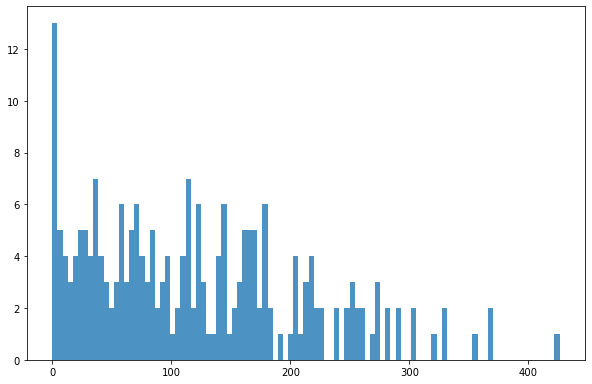

In [36]:
bins = np.linspace(min(predictors['TotalAGB']),max(predictors['TotalAGB']),100)
plt.hist((predictors['TotalAGB']),bins,alpha=0.8);

Clean the dataset by removing '0' AGB values

In [3]:
predictors_sel = predictors.loc[(predictors['TotalAGB'] != 0)]

Plotting response variables distribution after cleaning

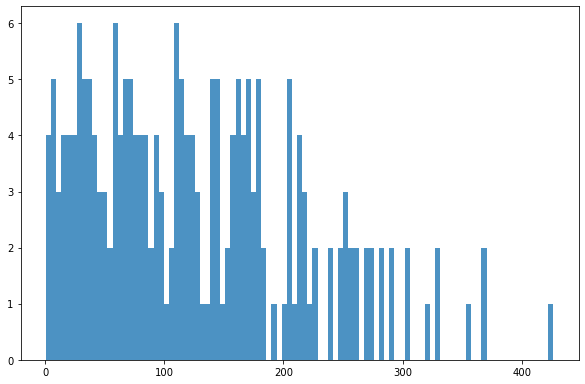

In [4]:
bins = np.linspace(min(predictors_sel['TotalAGB']),max(predictors_sel['TotalAGB']),100)
plt.hist((predictors_sel['TotalAGB']),bins,alpha=0.8);

In [106]:
#select the:
#target variable AGB
#predictor variables <- latitude, longitude, height percentiles and intensities

In [5]:
AGB = predictors_sel['TotalAGB'].to_numpy()
cols = [5,6,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125]
data = predictors_sel[predictors_sel.columns[cols]]
print(data.head())

   Ostkoordin  Nordkoordi  Elev P01  Elev P05  Elev P10   Elev P20  Elev P25  \
0      494081     6237269    1.5600    2.0295     2.379   3.278000    3.7500   
1      476547     6239273    1.6846    2.1900     3.252   4.762000    5.4800   
2      476282     6238964    6.9882    9.6300    11.464  13.197999   13.8750   
3      476268     6239247    1.5728    1.6960     1.790   1.998000    2.1900   
4      486266     6239102    2.0740    6.1450    11.005  16.719999   17.8225   

   Elev P30  Elev P40   Elev P50   Elev P60   Elev P70   Elev P75        p80  \
0     4.224     6.342   8.065001  10.006000  11.785000  12.265000  12.850000   
1     6.000     7.080   8.740000  11.148000  15.642000  16.680000  17.459999   
2    14.269    15.334  16.240000  17.120001  17.896999  18.299999  18.858000   
3     2.310     2.524   2.810000   3.004000   3.220000   3.300000   3.412000   
4    18.510    20.270  21.430000  22.690001  23.889999  24.289999  24.680000   

    Elev P90   Elev P95   Elev P99    

In [ ]:
#Explore the raw data - predictor variables

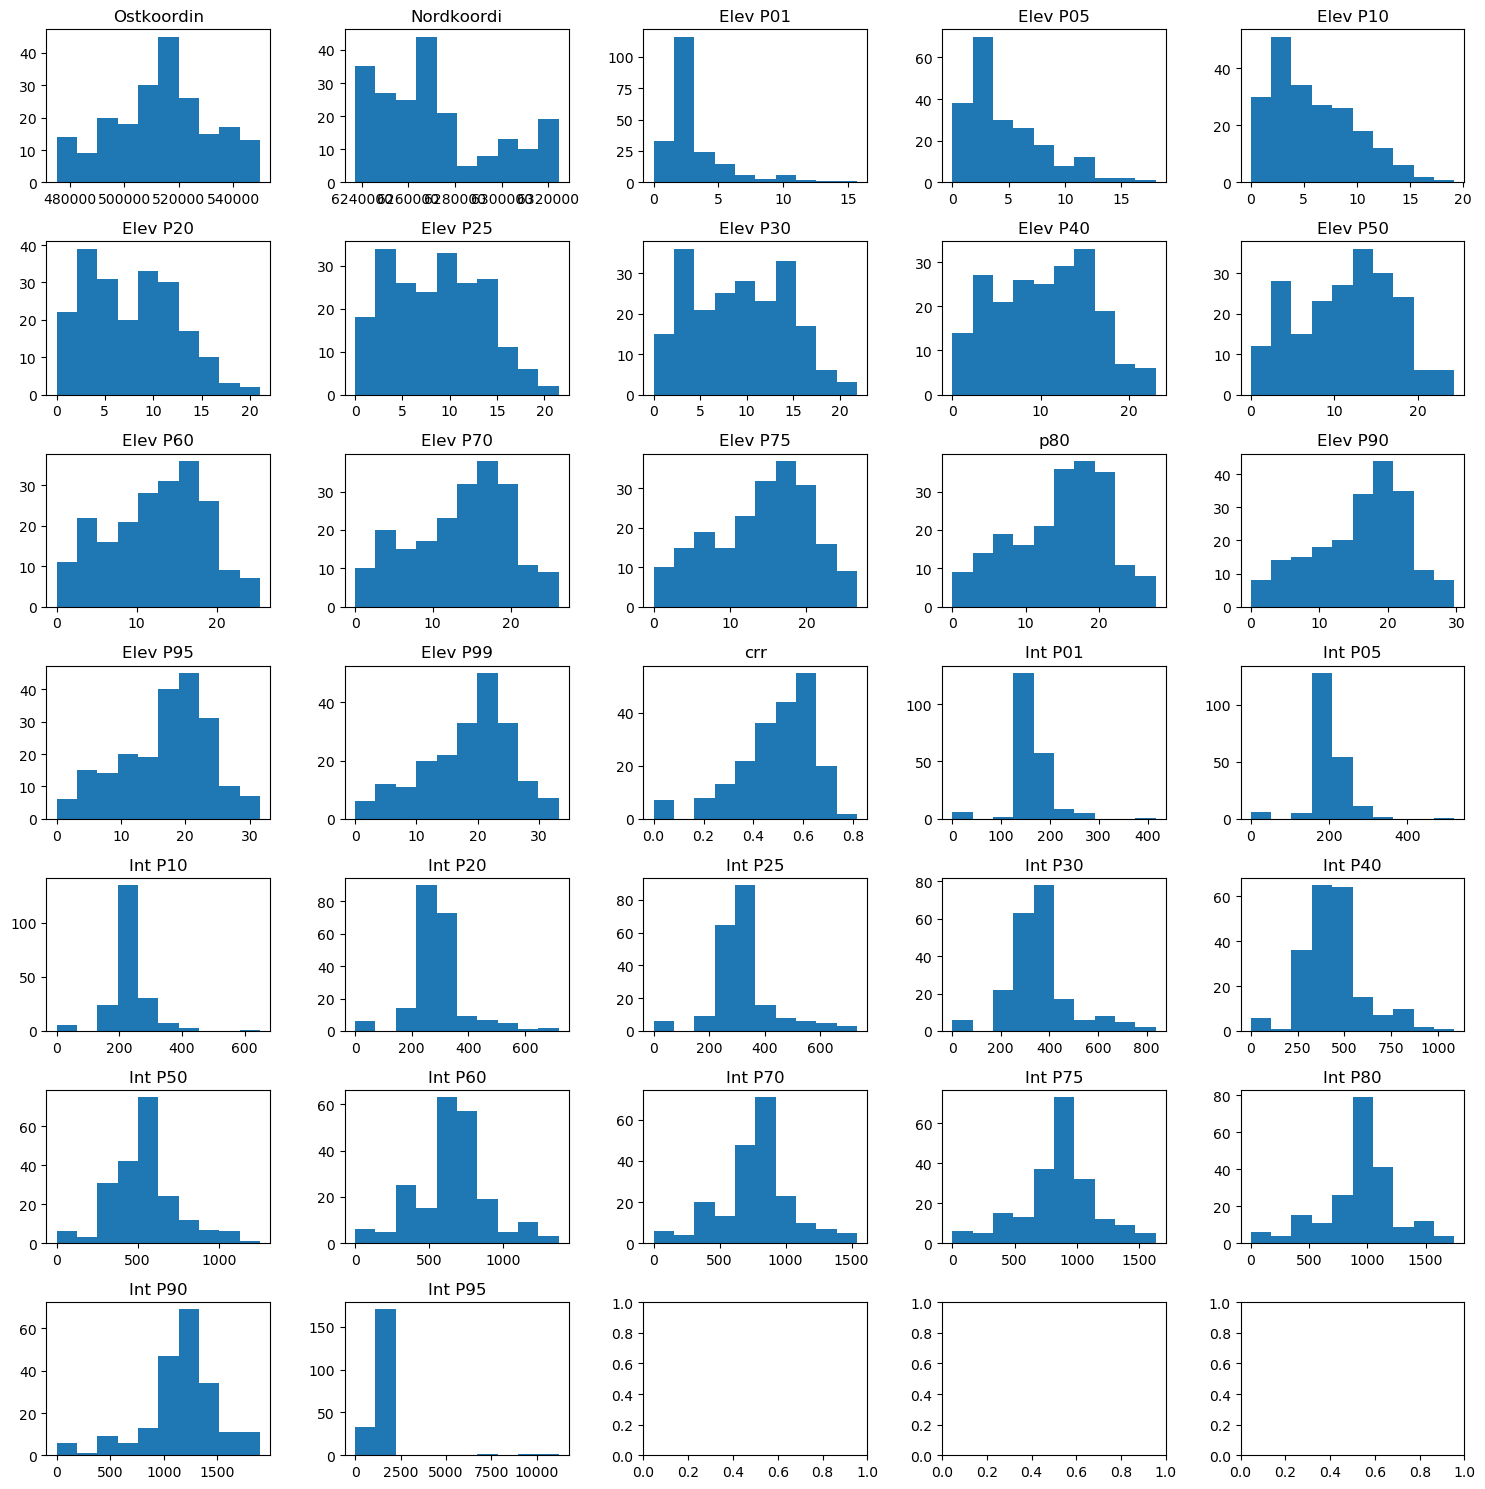

In [6]:
n_plots_x = int(np.ceil(np.sqrt(data.shape[1])))+1
n_plots_y = int(np.floor(np.sqrt(data.shape[1])))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(15,15), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(data.shape[1]-1):
    ax[idx].hist(data.iloc[:, idx].to_numpy().flatten())
    ax[idx].set_title(data.columns[idx])
fig.tight_layout()

In [107]:
#Normalize the target variable 'AGB' to range between 0 and 1 and to follow a normal distribution

/usr/lib/python3/dist-packages/sklearn/preprocessing/_data.py:2354: UserWarning: n_quantiles (500) is greater than the total number of samples (207). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  1.,  3.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 17., 16.,
        17., 15., 13., 11.,  9.,  7.,  5.,  3.,  3.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

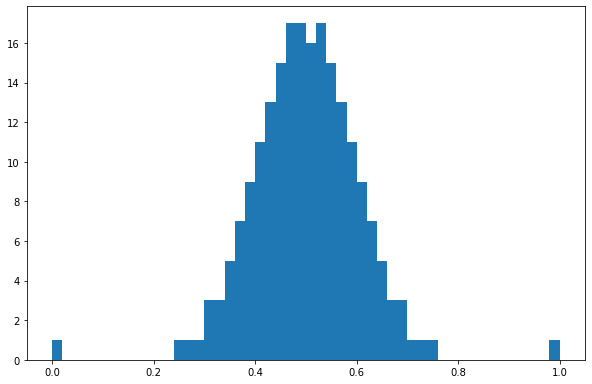

In [7]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
qt = QuantileTransformer(
    n_quantiles=500, output_distribution="normal", random_state=0
)
AGB = qt.fit_transform(AGB.reshape(-1,1))
scaler_tree = MinMaxScaler()
AGB = scaler_tree.fit_transform(AGB.reshape(-1,1)).squeeze()
plt.hist(AGB,50)

In [108]:
#Normalize the predictor variables to range between 0 and 1

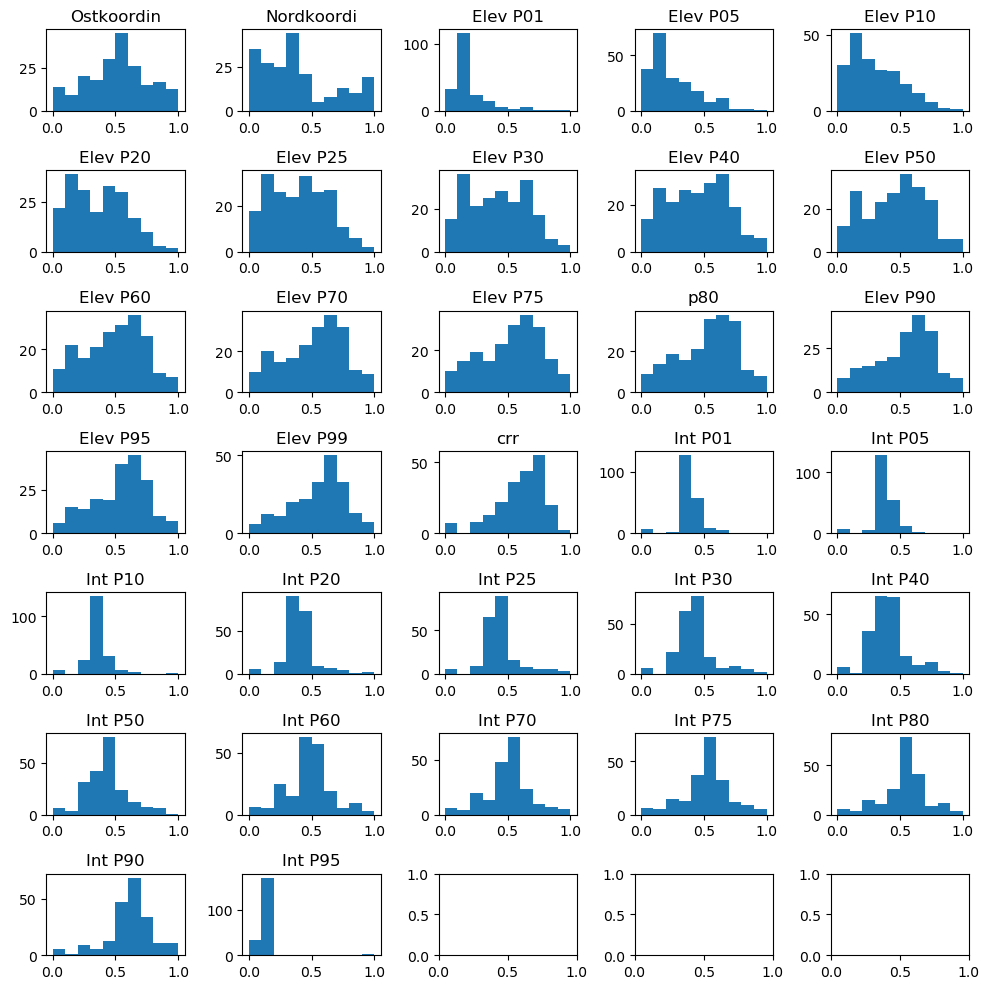

In [8]:
#Normalize the data
scaler_data = MinMaxScaler()
data_transformed = scaler_data.fit_transform(data)

n_plots_x = int(np.ceil(np.sqrt(data.shape[1])))+1
n_plots_y = int(np.floor(np.sqrt(data.shape[1])))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(data.shape[1]-1):
    ax[idx].hist(data_transformed[:,idx].flatten())
    ax[idx].set_title(data.columns[idx])
fig.tight_layout()

In [62]:
#Extract the column headers for later plotting the feature importance
featx = (data.columns.values)

## Random Forest Regression (RFR)

In [9]:
# Data splitting into train and test subsets
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(data_transformed,AGB, test_size=0.25, random_state=24)
y_train_rf = np.ravel(Y_train_rf)
y_test_rf = np.ravel(Y_test_rf)

In [10]:
# Define the RFR model
rfReg = RandomForestRegressor(min_samples_leaf=15, oob_score=True)
rfReg.fit(X_train_rf, y_train_rf)
dic_pred_RF = {}
dic_pred_RF['train'] = rfReg.predict(X_train_rf)
dic_pred_RF['test'] = rfReg.predict(X_test_rf)
pearsonr_train_RF = np.corrcoef(dic_pred_RF['train'],y_train_rf)**2
pearsonr_test_RF = np.corrcoef(dic_pred_RF['test'],y_test_rf)**2
pearsonr_all_RF = [pearsonr_train_RF[0,1],pearsonr_test_RF[0,1]]
pearsonr_all_RF

[0.5850426153769053, 0.634618398346184]

In [11]:
# checking the oob score
rfReg.oob_score_

0.4477686796959137

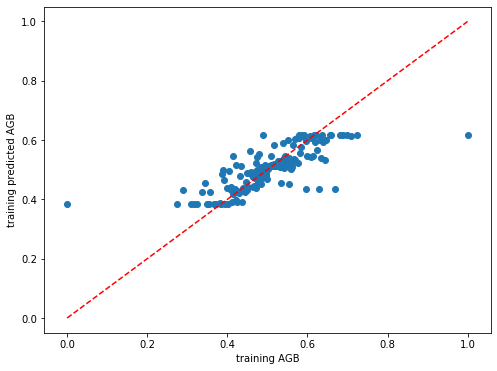

In [481]:
# Plot the model performance for the training set
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train_rf,dic_pred_RF['train'])
plt.xlabel('training AGB')
plt.ylabel('training predicted AGB')
ident = [0, 1]
plt.plot(ident,ident,'r--')

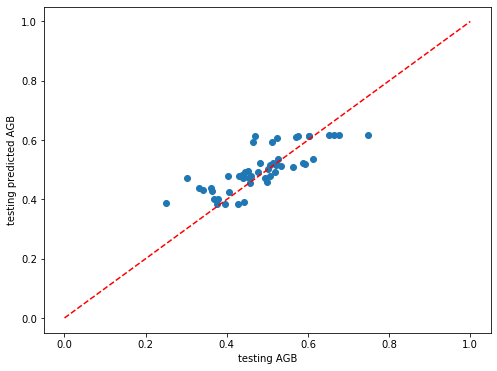

In [482]:
# Plot the model performance for the test set
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test_rf,dic_pred_RF['test'])
plt.xlabel('testing AGB')
plt.ylabel('testing predicted AGB')
ident = [0, 1]
plt.plot(ident,ident,'r--')

In [ ]:
# Compute the feature importance for the predictor variables

In [12]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [13]:
ind

array([30, 29, 26, 23, 22, 25, 24, 21, 27, 17, 28, 32,  0,  8, 20,  5, 31,
        6,  7, 13,  2, 14, 10,  1, 11, 16, 19, 18,  9,  3,  4, 15, 12])

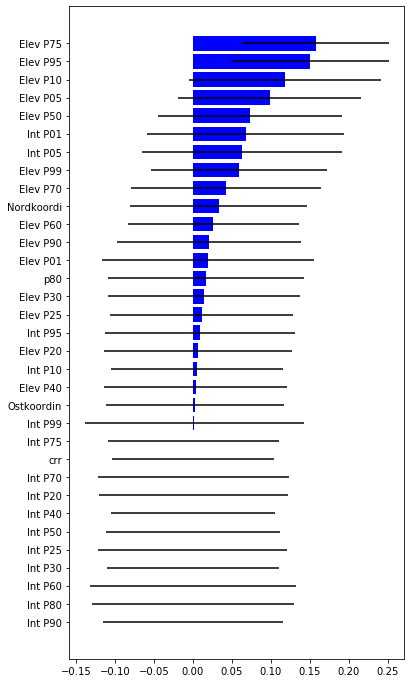

In [64]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(featx)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(featx)),featx[ind]);

In [65]:
# Model statistics
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(Y_test_rf, dic_pred_RF['test']))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(Y_test_rf, dic_pred_RF['test']))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(Y_test_rf, dic_pred_RF['test'], squared=False))
print('R^2:', metrics.r2_score(Y_test_rf, dic_pred_RF['test']))

Mean Absolute Error (MAE): 0.04844966911077575
Mean Squared Error (MSE): 0.003917523367916487
Root Mean Squared Error (RMSE): 0.06259012196757957
R^2: 0.5984579817055615


### Support Vector Machine for Regression (SVR)

In [115]:
# Dataset splitting into train and test data subsets
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(data_transformed,AGB, test_size=0.50, random_state=24)
print('X_train.shape:{}, X_test.shape:{} '.format(X_train_svr.shape, X_test_svr.shape))
scaler = MinMaxScaler()
X_train_svr = scaler.fit_transform(X_train_svr)
X_test_svr = scaler.transform(X_test_svr)

X_train.shape:(103, 33), X_test.shape:(104, 33) 


In [116]:
# Define the SVR model
svr = SVR(kernel='linear')
svr.fit(X_train_svr, y_train_svr) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train_svr, y_train_svr))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test_svr, y_test_svr)))

Accuracy of SVR on training set: 0.62139
Accuracy of SVR on test set: 0.56197


In [117]:
# Predict for the train and the test datasets
dic_pred_svr = {}
dic_pred_svr['train'] = svr.predict(X_train_svr)
dic_pred_svr['test'] = svr.predict(X_test_svr)

In [118]:
# Model statistics
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(dic_pred_svr['test'], y_test_svr, squared=False))
print('R^2:', metrics.r2_score(y_test_svr,dic_pred_svr['test']))

Root Mean Squared Error (RMSE): 0.07149401467860782
R^2: 0.5619712935228112


In [185]:
#on increasing/ decreasing the test_size the svr.score was increasing but the train score was going down

## Feedfoward neural network (FF-NN)

In [71]:
# Set a random seed
seed=29
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [72]:
#Split the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(data_transformed,AGB, test_size=0.7, random_state=0)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print('X_train.min: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.min(), X_test.min(), y_train.min(), y_test.min()))
print('X_train.max: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.max(), X_test.max(), y_train.max(), y_test.max()))

X_train.shape: torch.Size([62, 33]), X_test.shape: torch.Size([145, 33]), y_train.shape: torch.Size([62]), y_test.shape: torch.Size([145])
X_train.min: 0.0, X_test.shape: 0.0, y_train.shape: 0.0, y_test.shape: 0.25131121277809143
X_train.max: 1.0, X_test.shape: 1.0, y_train.shape: 0.7247803211212158, y_test.shape: 1.0


In [73]:
# Define the FeedForward Neural Network
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        # self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        # self.fc4 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        #self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        # hidden = self.relu(self.fc3(hidden))
        # hidden = self.relu(self.fc4(hidden))
        output = self.sigmoid(self.fc3(hidden))

        return output


hid_dim: 512, lr: 0.01
Epoch 0, train_loss: 0.0135, val_loss: 0.0112, r_value: -0.5676
Epoch 100, train_loss: 0.0128, val_loss: 0.0106, r_value: 0.1132
Epoch 200, train_loss: 0.0121, val_loss: 0.0101, r_value: 0.5879
Epoch 300, train_loss: 0.0116, val_loss: 0.0096, r_value: 0.6581
Epoch 400, train_loss: 0.0111, val_loss: 0.0091, r_value: 0.6764
Epoch 500, train_loss: 0.0107, val_loss: 0.0087, r_value: 0.6844
Epoch 600, train_loss: 0.0103, val_loss: 0.0084, r_value: 0.6887
Epoch 700, train_loss: 0.0100, val_loss: 0.0080, r_value: 0.6915
Epoch 800, train_loss: 0.0097, val_loss: 0.0077, r_value: 0.6936
Epoch 900, train_loss: 0.0094, val_loss: 0.0075, r_value: 0.6956
Epoch 1000, train_loss: 0.0091, val_loss: 0.0072, r_value: 0.6972
Epoch 1100, train_loss: 0.0089, val_loss: 0.0070, r_value: 0.6988
Epoch 1200, train_loss: 0.0087, val_loss: 0.0068, r_value: 0.7003
Epoch 1300, train_loss: 0.0085, val_loss: 0.0066, r_value: 0.7017
Epoch 1400, train_loss: 0.0084, val_loss: 0.0065, r_value: 0.70

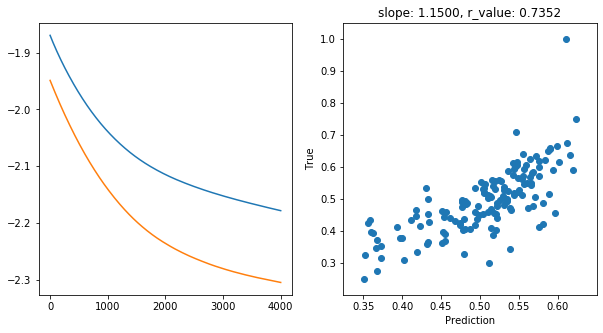

Saving model to  ./models/model_SGD_4000_lr0.01_hid_dim512


In [74]:
# FF-NN model.train()
epochs = 4000
hid_dim_range = [512]#,256
lr_range = [0.01]#,0.5,1]

#Let's create a place to save these models, so we can 
path_to_save_models = './models'
if not os.path.exists(path_to_save_models):
    os.makedirs(path_to_save_models)

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Feedforward(33, hid_dim)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test)
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test)
                all_loss_val.append(loss.item())
            
                if epoch%100==0:
                    y_pred = y_pred.detach().numpy().squeeze()
                    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(np.log10(all_loss_train))
        ax[0].plot(np.log10(all_loss_val))

        ax[1].scatter(y_pred, y_test)
        ax[1].set_xlabel('Prediction')
        ax[1].set_ylabel('True')
        ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()
        
        name_to_save = os.path.join(path_to_save_models,'model_SGD_' + str(epochs) + '_lr' + str(lr) + '_hid_dim' + str(hid_dim))
        print('Saving model to ', name_to_save)
        model_state = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
            }
        torch.save(model_state, name_to_save +'.pt')

In [75]:
# Define the function to compute model statistics
def make_preds(X_train,y_train,X_test,y_test):
    trainPredict = model(X_train)
    testPredict = model(X_test)
    trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    #print('Train R^2: ', r2_score(y_train, trainPredict))
    testScore = np.sqrt(mean_squared_error(y_test, testPredict))
    #print('Train R^2: ', r2_score(y_test, testPredict))
    print('TMetrics RMSE: %.2f RMSE' % (testScore))
    
    return trainPredict, testPredict

In [76]:
# Model statistics
model.eval()
with torch.no_grad():
    make_preds(X_train,y_train.reshape(-1,1),X_test,y_test.reshape(-1,1))

Train Score: 0.08 RMSE
TMetrics RMSE: 0.07 RMSE


In [77]:
# To compute the feature importance for the predictor variables
import shap

test_set= X_test
test_labels= y_test

explainer = shap.DeepExplainer(model, X_test)
shap_values = explainer.shap_values(test_set)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(145, 33)


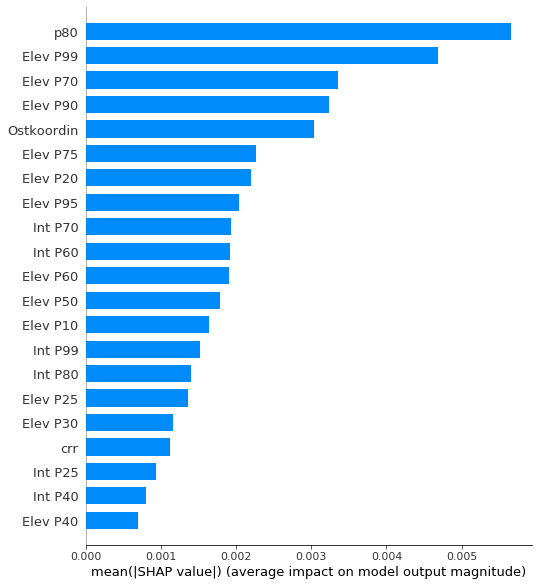

In [100]:
#SHAP global interpretation
# The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

print(shap_values.shape)
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = data.columns, max_display=21)

In [119]:
# Tabular rerpesentation of the model statistics summary of the above 3 models used (RFR, SVR, FF-NN)
print(tabulate([['RFR', round(metrics.mean_squared_error(y_test_rf, dic_pred_RF['test'], squared=False),2),
round(metrics.r2_score(y_test_rf, dic_pred_RF['test']),2)], ['SVR', round(metrics.mean_squared_error(y_test_svr, dic_pred_svr['test'], squared=False),2),
round(metrics.r2_score(y_test_svr,dic_pred_svr['test']),2)], ['FeedF NN', '0.07', 0.59]], headers=['Algorithm', 'RMSE', 'R^2'])) #['GLM', 63.49, 0.45]

Algorithm      RMSE    R^2
-----------  ------  -----
RFR            0.06   0.6
SVR            0.07   0.56
FeedF NN       0.07   0.59


In [120]:
# RFR and FF-NN was performing very similar with R^2 and RMSE values either similar/higher/lower compared to eachother.
#Therefore, the data represented in the above table is for one random instance.

### Predict the raster using RFR

In [81]:
# Define RFR with the 2 predictor variables corresponding to the available rasters
X_rf2 = predictors_sel.iloc[:,[86,90]].values
Y_rf2 = predictors_sel.iloc[:,15:16].values
X_train_rf2, X_test_rf2, Y_train_rf2, Y_test_rf2 = train_test_split(X_rf2, Y_rf2, test_size=0.25, random_state=24)
y_train_rf2 = np.ravel(Y_train_rf2)
y_test_rf2 = np.ravel(Y_test_rf2)
rfReg_rf2 = RandomForestRegressor(min_samples_leaf=20, oob_score=True)
rfReg_rf2.fit(X_train_rf2, y_train_rf2);
dic_pred_rf2 = {}
dic_pred_rf2['train'] = rfReg_rf2.predict(X_train_rf2)
dic_pred_rf2['test'] = rfReg_rf2.predict(X_test_rf2)
#print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test_rf2, dic_pred_rf2['test']))
#print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test_rf2, dic_pred_rf2['test']))
#print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test_rf2, dic_pred_rf2['test'], squared=False))
#print('R^2:', metrics.r2_score(y_test_rf2, dic_pred_rf2['test']))

Mean Absolute Error (MAE): 41.108253168570315
Mean Squared Error (MSE): 2699.6832371086425
Root Mean Squared Error (RMSE): 51.95847608531877
R^2: 0.6374537638503947


In [82]:
# Bash commands to crop the rasters for extracting a sub-area from the study region
#%%bash
#gdalwarp -cutline sub-area.shp -crop_to_cutline -dstalpha P80_t2.tif p80_t2_crop.tif
#gdalwarp -cutline sub-area.shp -crop_to_cutline -dstalpha CanopyReliefRatio_t2.tif crr_t2_crop.tif

In [83]:
# Import rasters
p80 = rasterio.open("../images/p80_t2_crop.tif")
crr = rasterio.open("../images/crr_t2_crop.tif")

In [84]:
# Stack the 2 raster layers correspong to the predictor variables
#predictors_rasters = [p80,crr]
stack = Raster(p80,crr)

In [85]:
# Check the dimension of the raster stack to be given as input to the RFR
stack.count

2

In [86]:
# Predict the raster for the target variable 'AGB'
result = stack.predict(estimator=rfReg_rf2, dtype='int16', nodata=-1)
print(result)

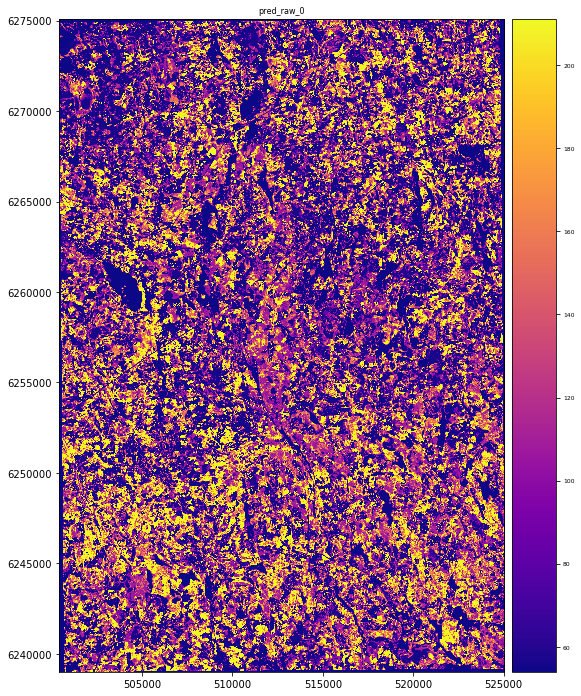

In [87]:
# Plot the resultin g map
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()